# Carbon Emission Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('emissions_high_granularity.csv')

In [3]:
df.head(3)

,year,parent_entity,parent_type,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,source
0,1962,Abu Dhabi National Oil Company,State-owned Entity,Abu Dhabi,Oil & NGL,0.9125,Million bbl/yr,0.338928,0.005404,0.001299,0.0,0.018254,0.000652,0.024957,0.363885,Abu Dhabi National Oil Company Annual Report 1...
1,1963,Abu Dhabi National Oil Company,State-owned Entity,Abu Dhabi,Oil & NGL,1.8250,Million bbl/yr,0.677855,0.010808,0.002598,0.0,0.036508,0.001304,0.049914,0.727770,Abu Dhabi National Oil Company Annual Report 1...
2,1964,Abu Dhabi National Oil Company,State-owned Entity,Abu Dhabi,Oil & NGL,7.3000,Million bbl/yr,2.711422,0.043233,0.010392,0.0,0.146033,0.005215,0.199657,2.911079,Abu Dhabi National Oil Company Annual Report 1...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15797 entries, 0 to 15796
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                15797 non-null  int64  
 1   parent_entity                       15797 non-null  object 
 2   parent_type                         15797 non-null  object 
 3   reporting_entity                    15797 non-null  object 
 4   commodity                           15797 non-null  object 
 5   production_value                    15797 non-null  float64
 6   production_unit                     15797 non-null  object 
 7   product_emissions_MtCO2             15797 non-null  float64
 8   flaring_emissions_MtCO2             15797 non-null  float64
 9   venting_emissions_MtCO2             15797 non-null  float64
 10  own_fuel_use_emissions_MtCO2        15797 non-null  float64
 11  fugitive_methane_emissions_MtCO2e   15797

In [5]:
df.describe()

,year,production_value,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,fugitive_methane_emissions_MtCH4,total_operational_emissions_MtCO2e,total_emissions_MtCO2e
count,15797.000000,15797.000000,15797.000000,15797.000000,15797.000000,15797.000000,15797.000000,15797.000000,15797.000000,15797.000000
mean,1985.827942,327.879634,79.391514,0.517226,0.462462,0.688676,8.884203,0.317293,10.552566,89.944080
std,28.664256,1188.625001,261.984080,1.783744,1.804575,3.564171,31.358244,1.119937,34.790479,292.843491
min,1854.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1970.000000,11.800000,5.996490,0.000000,0.000000,0.000000,0.607068,0.021681,0.751999,7.208860
50%,1993.000000,59.970871,21.502409,0.015913,0.045247,0.000000,2.351126,0.083969,2.869611,25.116721
75%,2007.000000,246.375000,62.191954,0.197253,0.329719,0.162415,7.401655,0.264345,8.965620,72.255340
max,2022.000000,27192.000000,7769.222235,27.026872,41.458662,83.203465,877.683714,31.345847,877.683714,8646.905949


In [6]:
df.shape

(15797, 16)

#### Data Preprocessing

In [7]:
df.isnull().sum()

year                                  0
parent_entity                         0
parent_type                           0
reporting_entity                      0
commodity                             0
production_value                      0
production_unit                       0
product_emissions_MtCO2               0
flaring_emissions_MtCO2               0
venting_emissions_MtCO2               0
own_fuel_use_emissions_MtCO2          0
fugitive_methane_emissions_MtCO2e     0
fugitive_methane_emissions_MtCH4      0
total_operational_emissions_MtCO2e    0
total_emissions_MtCO2e                0
source                                0
dtype: int64

In [8]:
# handle duplicates
duplicates = df.duplicated().sum()
print(f'Duplicates: {duplicates}')

Duplicates: 0


In [9]:
# looking for outliers
numeric_columns = df.select_dtypes(include=[np.number]).columns
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) |(df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

<Axes: xlabel='production_value', ylabel='Count'>

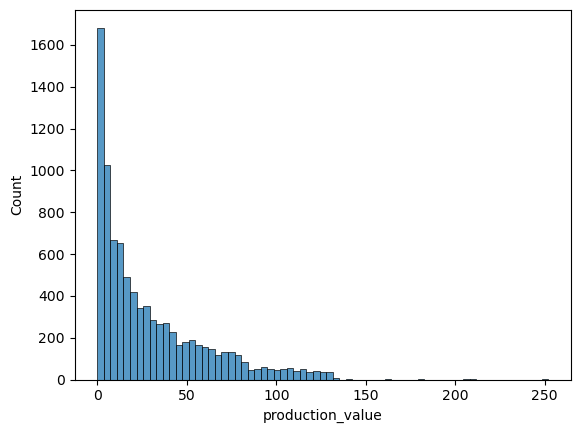

In [10]:
sns.histplot(data=df,x='production_value')

In [11]:
# Check Normalization
stat, p = shapiro(df['production_value'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

if p < 0.05:
    transformer = PowerTransformer()
    df['production_value'] = transformer.fit_transform(df[['production_value']])

Statistics=0.836, p=0.000


c:\Users\hsman\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Exploratory Data Analysis

#### Trends over Years

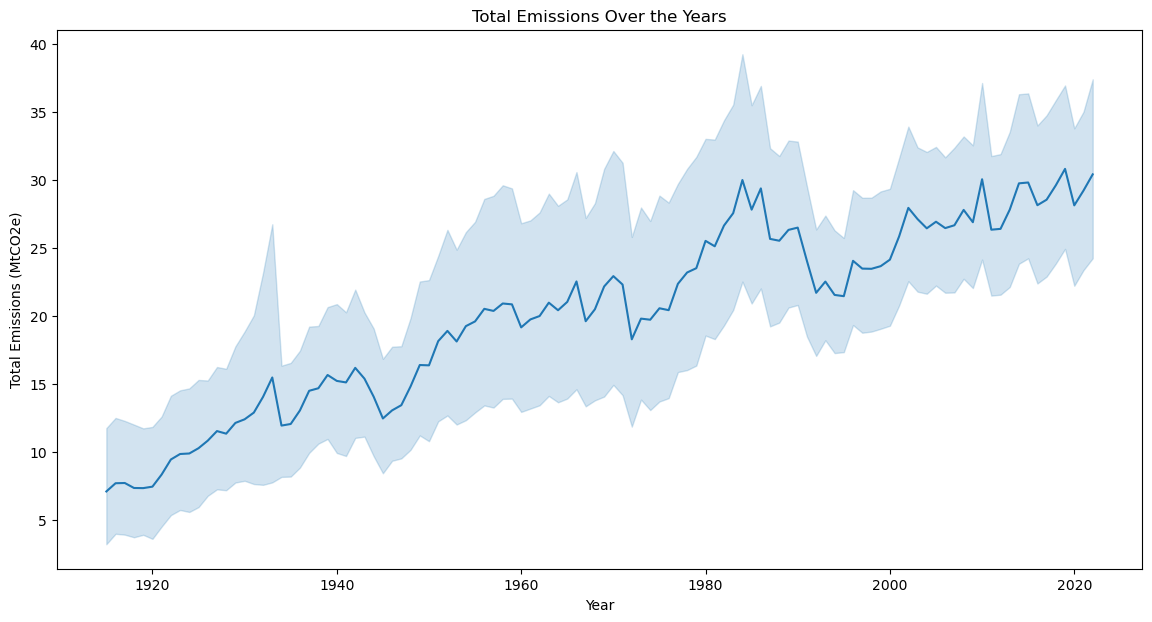

In [12]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='year', y='total_emissions_MtCO2e')
plt.title('Total Emissions Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Emissions (MtCO2e)')
plt.show()

The line plot shows a clear upward trend in total emissions (MtCO2e) from the early 1900s to 2020.

- **Pre-1940s**: Emissions were relatively low and sporadic.
- **1940s to 1980s**: There was a steady increase in emissions, indicating industrial growth.
- **1980s to 2020**: Emissions continued to rise significantly, with higher and more frequent spikes, reflecting rapid industrialization and economic growth globally.

Overall, the plot highlights a significant increase in emissions over the past century.

#### Production Value vs Total Emissions

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8876 entries, 0 to 15749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                8876 non-null   int64  
 1   parent_entity                       8876 non-null   object 
 2   parent_type                         8876 non-null   object 
 3   reporting_entity                    8876 non-null   object 
 4   commodity                           8876 non-null   object 
 5   production_value                    8876 non-null   float64
 6   production_unit                     8876 non-null   object 
 7   product_emissions_MtCO2             8876 non-null   float64
 8   flaring_emissions_MtCO2             8876 non-null   float64
 9   venting_emissions_MtCO2             8876 non-null   float64
 10  own_fuel_use_emissions_MtCO2        8876 non-null   float64
 11  fugitive_methane_emissions_MtCO2e   8876 non-nu

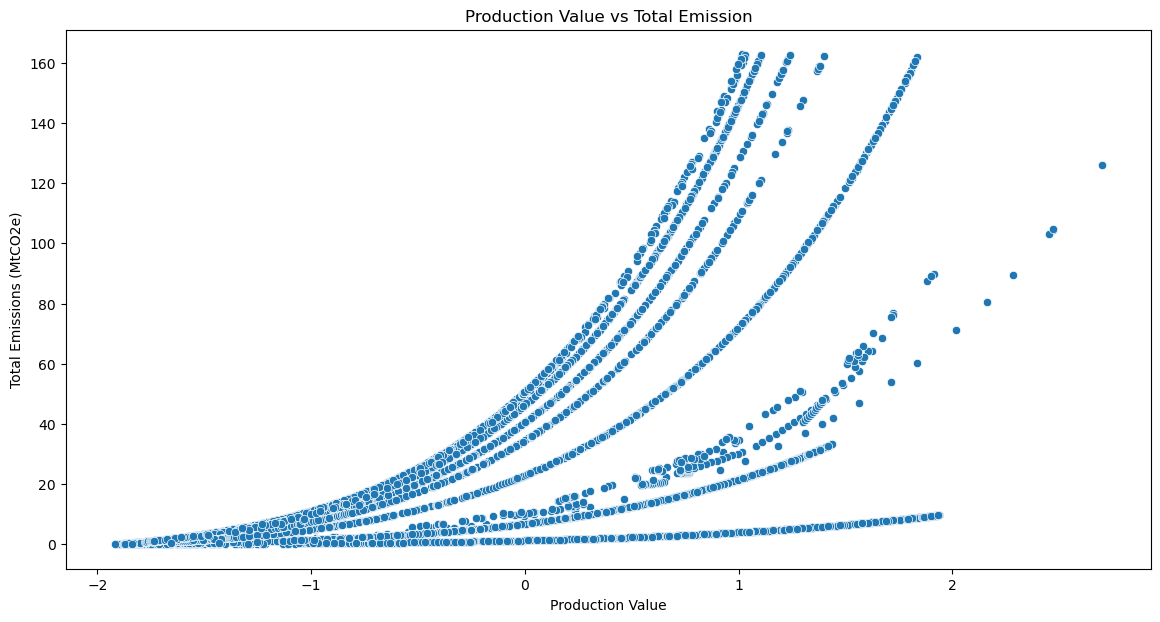

In [14]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df,x='production_value',y='total_emissions_MtCO2e')
plt.title('Production Value vs Total Emission')
plt.xlabel('Production Value')
plt.ylabel('Total Emissions (MtCO2e)')
plt.show()

The scatter plot illustrates the relationship between production value and total emissions (MtCO2e). Here are the key observations:

- **Positive Correlation**: There is a clear positive correlation between production value and total emissions. As production value increases, total emissions also tend to increase.
- **Curved Relationship**: The data points form a curved pattern, suggesting a non-linear relationship where emissions rise more sharply at higher production values.
- **Clusters of Data**: The plot shows distinct clusters of data points, indicating groups of entities with similar production values and emissions levels.

Overall, the plot highlights that higher production values are associated with significantly higher total emissions.

#### Commodity Distribution

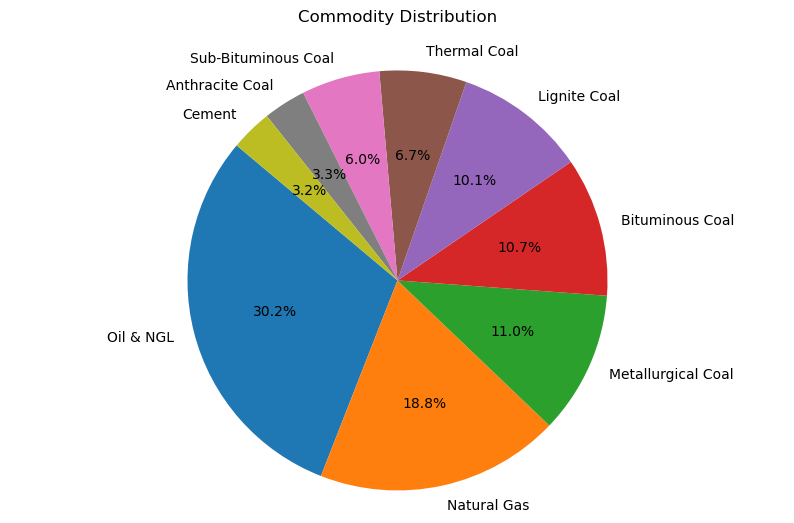

In [15]:
commodity_counts = df['commodity'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(commodity_counts, labels=commodity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Commodity Distribution', pad=20)
plt.axis('equal')
plt.show()

The pie chart illustrates the distribution of different commodities. Here are the key observations:

- **Oil & NGL**: Represents the largest share at 30.2% of the total commodity distribution.
- **Natural Gas**: Accounts for 18.8%, making it the second largest commodity.
- **Metallurgical Coal**: Holds 11.0% of the distribution.
- **Bituminous Coal**: Comprises 10.7% of the commodities.
- **Lignite Coal**: Makes up 10.1% of the distribution.
- **Other Commodities**: Include Thermal Coal, Sub-Bituminous Coal, Anthracite Coal, Cement, and Sub-Bituminous Coal, each with smaller shares ranging from 3.2% to 6.7%.

Overall, the chart highlights that Oil & NGL and Natural Gas are the predominant commodities in the distribution.

#### Emission Types in Subplots

In [16]:
df.columns

Index(['year', 'parent_entity', 'parent_type', 'reporting_entity', 'commodity',
       'production_value', 'production_unit', 'product_emissions_MtCO2',
       'flaring_emissions_MtCO2', 'venting_emissions_MtCO2',
       'own_fuel_use_emissions_MtCO2', 'fugitive_methane_emissions_MtCO2e',
       'fugitive_methane_emissions_MtCH4',
       'total_operational_emissions_MtCO2e', 'total_emissions_MtCO2e',
       'source'],
      dtype='object')

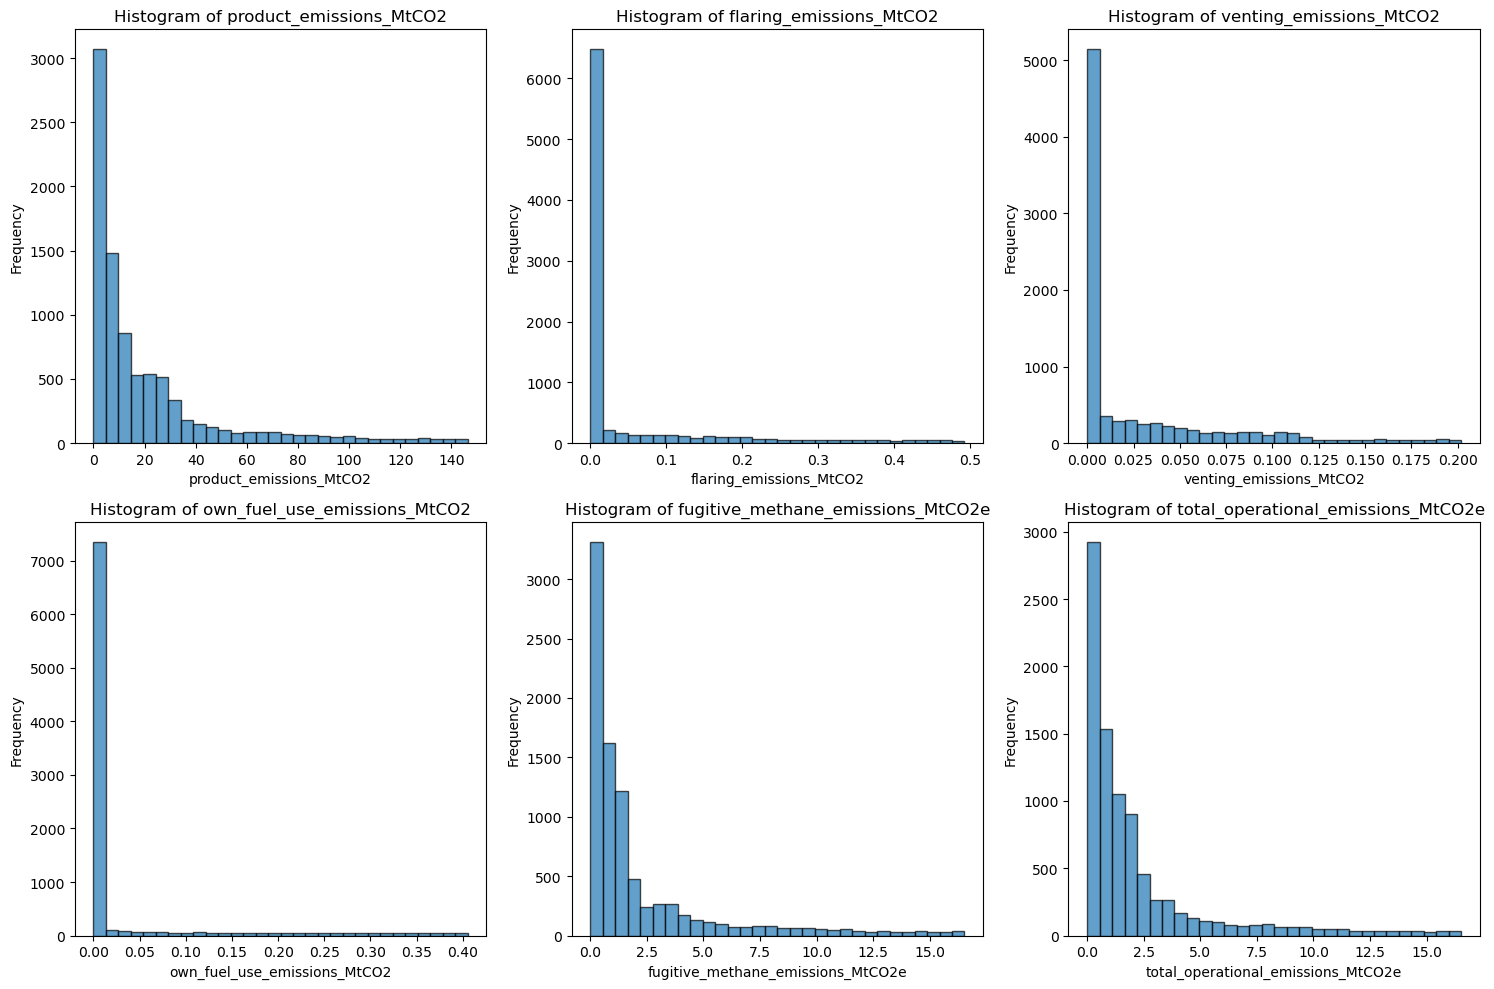

In [17]:
emission_columns = ['product_emissions_MtCO2','flaring_emissions_MtCO2', 'venting_emissions_MtCO2','own_fuel_use_emissions_MtCO2', 'fugitive_methane_emissions_MtCO2e','total_operational_emissions_MtCO2e']
n_cols = 3
n_rows = (len(emission_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, column in enumerate(emission_columns):
    axes[i].hist(df[column], bins=30, edgecolor='k', alpha=0.7)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The subplots display the distribution of various emission types. Here are the key observations:

1. **Product Emissions**:
   - Most values are clustered between 0 and 20 MtCO2, with a long tail extending to higher values.

2. **Flaring Emissions**:
   - Predominantly low values, mostly concentrated around 0 MtCO2, with very few instances exceeding 0.1 MtCO2.

3. **Venting Emissions**:
   - Similar to flaring emissions, values are mostly close to 0 MtCO2, with few occurrences above 0.05 MtCO2.

4. **Own Fuel Use Emissions**:
   - Almost all values are close to 0 MtCO2, indicating minimal emissions from own fuel use.

5. **Fugitive Methane Emissions**:
   - The majority of values are below 2.5 MtCO2e, with some extending up to 15 MtCO2e.

6. **Total Operational Emissions**:
   - The distribution is skewed towards lower values, with most emissions below 2.5 MtCO2e and a long tail up to 15 MtCO2e.

Overall, the histograms reveal that emissions are generally low for most types, with a few high-emission outliers.

#### Correlation Matrix

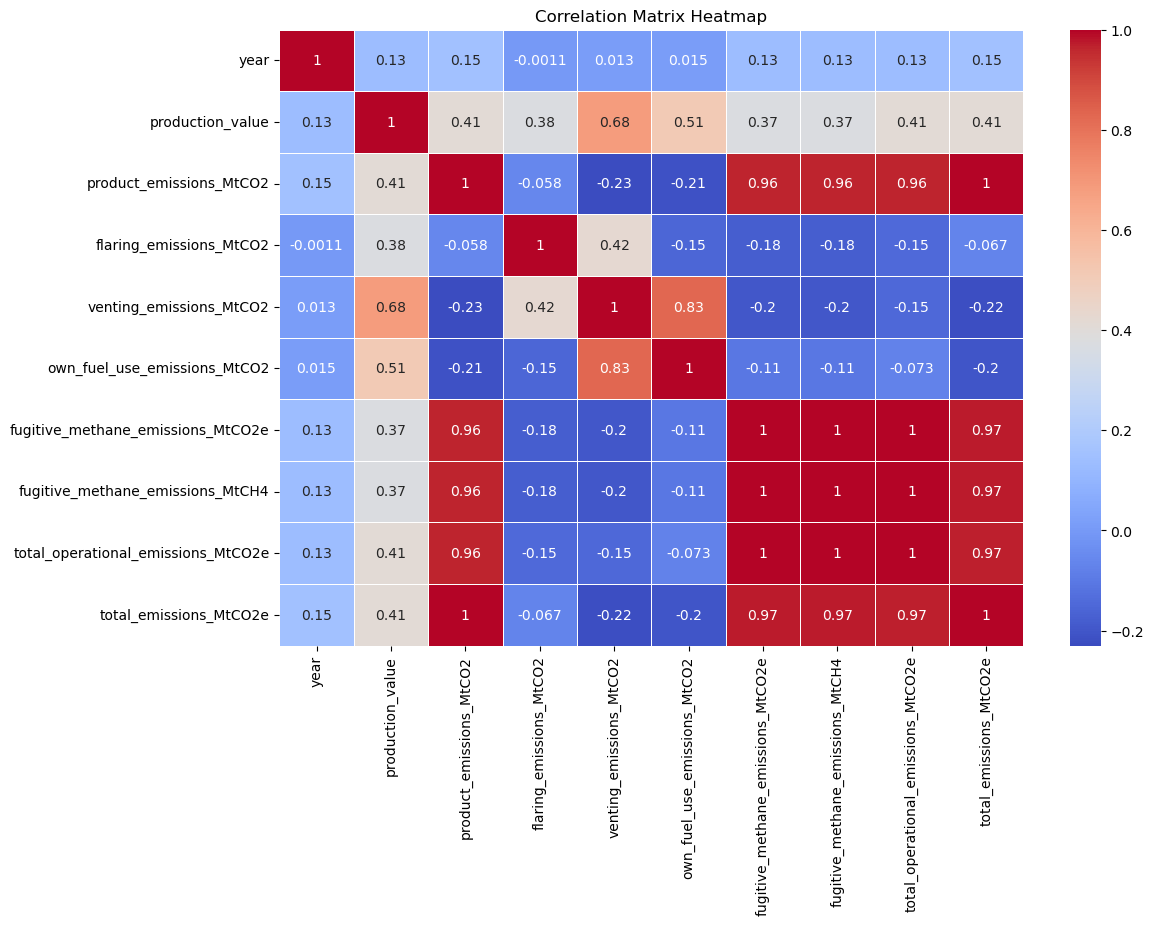

In [18]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix heatmap displays the relationships between different numeric variables in the dataset. Here are the key observations:

- **High Correlation**: 
  - `product_emissions_MtCO2` has a very high correlation (0.96) with both `fugitive_methane_emissions_MtCO2e` and `total_operational_emissions_MtCO2e`.
  - `own_fuel_use_emissions_MtCO2` and `venting_emissions_MtCO2` are also highly correlated (0.83).
  - `total_emissions_MtCO2e` is highly correlated with `total_operational_emissions_MtCO2e` (0.97), indicating these variables are closely related.

- **Moderate Correlation**:
  - `production_value` has moderate correlations with `own_fuel_use_emissions_MtCO2` (0.51) and `venting_emissions_MtCO2` (0.68).

- **Low/Negative Correlation**: 
  - There are low or negative correlations among other pairs, such as `flaring_emissions_MtCO2` with most other variables, indicating minimal or inverse relationships.

Overall, the heatmap highlights that certain types of emissions are strongly correlated, especially `product_emissions_MtCO2`, `fugitive_methane_emissions_MtCO2e`, and `total_operational_emissions_MtCO2e`.

#### Parent Entity Distribution

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8876 entries, 0 to 15749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                8876 non-null   int64  
 1   parent_entity                       8876 non-null   object 
 2   parent_type                         8876 non-null   object 
 3   reporting_entity                    8876 non-null   object 
 4   commodity                           8876 non-null   object 
 5   production_value                    8876 non-null   float64
 6   production_unit                     8876 non-null   object 
 7   product_emissions_MtCO2             8876 non-null   float64
 8   flaring_emissions_MtCO2             8876 non-null   float64
 9   venting_emissions_MtCO2             8876 non-null   float64
 10  own_fuel_use_emissions_MtCO2        8876 non-null   float64
 11  fugitive_methane_emissions_MtCO2e   8876 non-nu

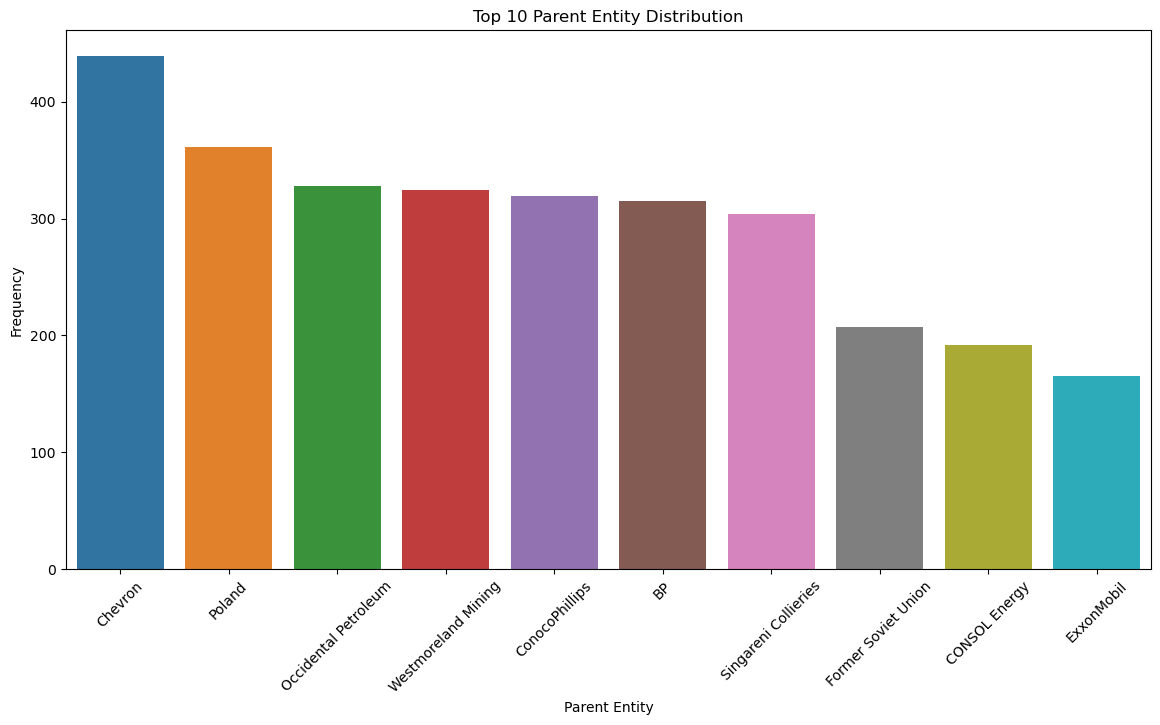

In [20]:
parent_entity_counts = df['parent_entity'].value_counts().head(10)
parent_entity_df = parent_entity_counts.reset_index()
parent_entity_df.columns = ['Parent Entity', 'Frequency']
plt.figure(figsize=(14, 7))
sns.barplot(data=parent_entity_df,x='Parent Entity' ,y='Frequency')
plt.title('Top 10 Parent Entity Distribution')
plt.xlabel('Parent Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

The bar plot displays the distribution of the top 10 parent entities based on frequency. Here are the key observations:

- **Chevron**: Has the highest frequency among the parent entities, indicating it is the most prominent entity in the dataset.
- **Poland, Occidental Petroleum, Westmoreland Mining, Conocophillips, BP, Singareni Collieries**: These entities have similar frequencies, showcasing their significant presence.
- **Former Soviet Union, CONSOL Energy, ExxonMobil**: These entities have relatively lower frequencies compared to the others but are still among the top 10.

Overall, Chevron stands out as the most frequent parent entity, followed by a mix of international and national corporations.


#### Top emitters by parent_entity, comparing emissions from investor-owned companies, state-owned companies, and nation-states

In [21]:
df.columns

Index(['year', 'parent_entity', 'parent_type', 'reporting_entity', 'commodity',
       'production_value', 'production_unit', 'product_emissions_MtCO2',
       'flaring_emissions_MtCO2', 'venting_emissions_MtCO2',
       'own_fuel_use_emissions_MtCO2', 'fugitive_methane_emissions_MtCO2e',
       'fugitive_methane_emissions_MtCH4',
       'total_operational_emissions_MtCO2e', 'total_emissions_MtCO2e',
       'source'],
      dtype='object')

In [33]:
top_emitters = df.groupby(['parent_type','parent_entity'])['total_emissions_MtCO2e'].sum().reset_index()
top_emitters = top_emitters.sort_values(by=['parent_type', 'total_emissions_MtCO2e'], ascending=False)
top_emitters['rank'] = top_emitters.groupby('parent_type')['total_emissions_MtCO2e'].rank(method='dense', ascending=False)
top_5_emitters = top_emitters[top_emitters['rank'] <= 5]
top_5_emitters

,parent_type,parent_entity,total_emissions_MtCO2e,rank
90,State-owned Entity,Coal India,3877.635118,1.0
113,State-owned Entity,Singareni Collieries,3290.960689,2.0
86,State-owned Entity,Bapco Energies,886.558419,3.0
88,State-owned Entity,CNOOC,801.134576,4.0
117,State-owned Entity,Syrian Petroleum,577.727880,5.0
81,Nation State,Poland,17198.944057,1.0
78,Nation State,Former Soviet Union,13335.954409,2.0
75,Nation State,China (Coal),7022.190073,3.0
82,Nation State,Russian Federation,6572.437202,4.0
77,Nation State,Czechoslovakia,5517.459629,5.0


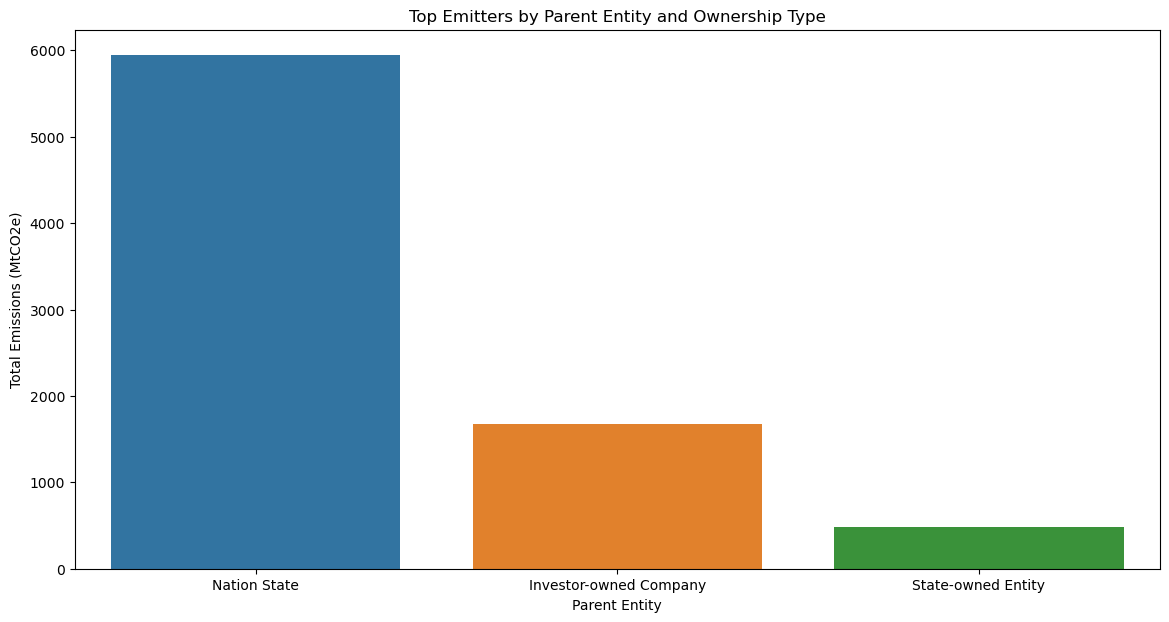

In [23]:
plt.figure(figsize=(14, 7))
sns.barplot(data=top_emitters, x='parent_type', y='total_emissions_MtCO2e',errorbar=None)
plt.title('Top Emitters by Parent Entity and Ownership Type')
plt.xlabel('Parent Entity')
plt.ylabel('Total Emissions (MtCO2e)')
# plt.xticks(rotation=45)
plt.show()

#### Commodity Wise Analysis

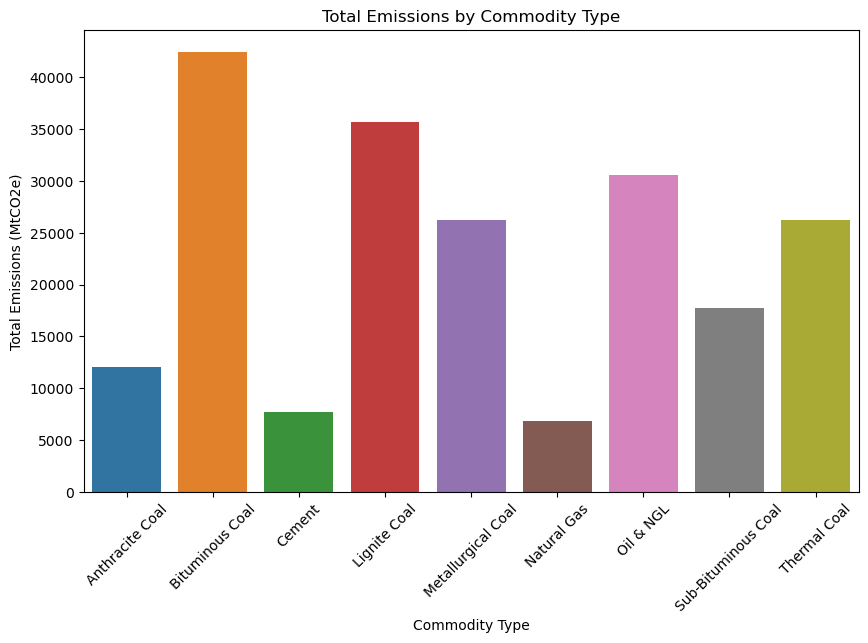

In [35]:
commodity_emission = df.groupby('commodity')['total_emissions_MtCO2e'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=commodity_emission, x='commodity', y='total_emissions_MtCO2e')
plt.title('Total Emissions by Commodity Type')
plt.xlabel('Commodity Type')
plt.ylabel('Total Emissions (MtCO2e)')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

In [36]:
df = pd.get_dummies(df, columns=['parent_entity', 'parent_type', 'reporting_entity', 'commodity', 'production_unit', 'source'], drop_first=True)

### Model Training

In [37]:
#train test split
X = df.drop(columns=['year','total_emissions_MtCO2e'])
Y = df['total_emissions_MtCO2e']
X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [38]:
#model training and evaluation
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [39]:
# Evaluation Metrics
mse = mean_squared_error(Y_test,Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 0.022874018910123705
Mean Absolute Error: 0.02877789034583375
R-squared: 0.9999780761437326
Root Mean Squared Error: 0.15124159120468056


Plotting Actual vs Predicted Emissions

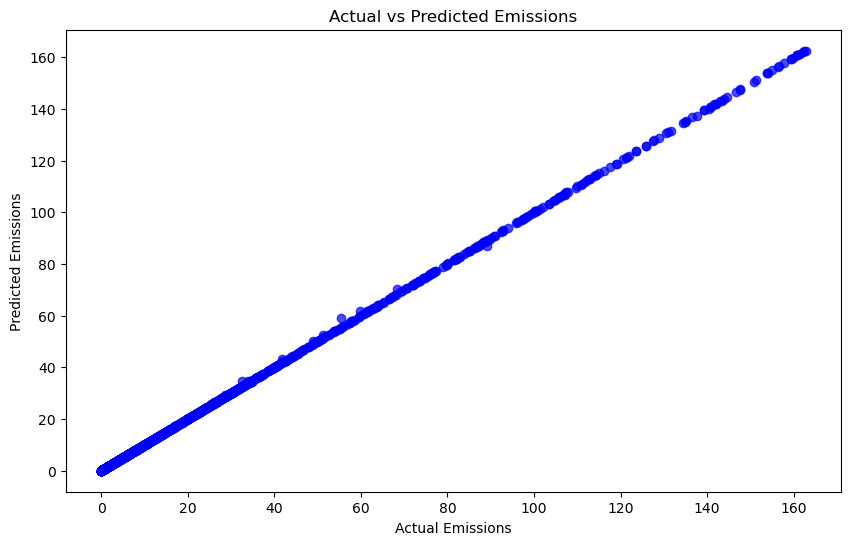

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.7, color='b')
plt.xlabel('Actual Emissions')
plt.ylabel('Predicted Emissions')
plt.title('Actual vs Predicted Emissions')
plt.show()

The plot compares the actual emissions with the predicted emissions. Here are the key observations:

- **Linear Relationship**: The points lie almost perfectly along the diagonal line, indicating a strong linear relationship between actual and predicted values.
- **High Accuracy**: The close alignment of points with the diagonal suggests that the model predicts emissions with high accuracy.
- **Minimal Deviation**: There is minimal deviation from the diagonal, highlighting that the predicted emissions closely match the actual emissions across the entire range.

Overall, the plot demonstrates that the model performs exceptionally well in predicting emissions, with high accuracy and minimal errors.